In [11]:
from htc_class_testing import HolsteinTavisCummings
import numpy as np
from qutip import *
from qutip.core.gates import *
from numpy import array
from numpy import real
import matplotlib.pyplot as plt
pi = np.pi
LiH_params = {
    'w_q1': 0.12086,         # Qubit 1 frequency in a.u.
    'w_q2': 0.12086,         # Qubit 2 frequency
    'w_vib1': 0.00622913,       # Vibrational mode 1 frequency
    'w_vib2': 0.00622913,      # Vibrational mode 2 frequency
    'w_cav': 0.12086,        # Cavity frequency
    'S_1':  10.5615447 * 0 ,         # Huang-Rhys factor for qubit 1 and vib 1
    'S_2':  10.5615447 * 0,         # Huang-Rhys factor for qubit 2 and vib 2
    'lambda_1': 0.01,     # Cavity coupling strength for qubit 1
    'lambda_2': 0.01,    # Cavity coupling strength for qubit 2
    'N_vib': 2,         # Number of vibrational states to include
    'N_cav': 2,          # Cavity truncation level
    'qubit_1_dipole_moments' : 
    { 
        'mu_g': -2.354965266795868, #ground dipole moment
        'mu_e': 2.0510843691207983, #excited dipole moment
        'mu_eg': 1.0338263686725813 #transition dipole moment
    },
    'qubit_2_dipole_moments' : 
    { 
        'mu_g': -2.354965266795868, #ground dipole moment
        'mu_e': 2.0510843691207983, #excited dipole moment
        'mu_eg': 1.0338263686725813 #transition dipole moment
    }
}

In [12]:
# define variables
w1 = LiH_params['w_q1']
w2 = LiH_params['w_q2']
wc = LiH_params['w_cav']
v1 = LiH_params['w_vib1']
v2 = LiH_params['w_vib2']
_lambda_1 = np.sqrt(LiH_params['S_1'])
_lambda_2 = np.sqrt(LiH_params['S_2'])
lambda_1 = LiH_params['lambda_1']
lambda_2 = LiH_params['lambda_2']
mu_1 = LiH_params['qubit_1_dipole_moments']
mu_2 = LiH_params['qubit_2_dipole_moments']
vibrational_zero_point = 0.0
qubit_zero_point = 0.0 
cavity_zero_point = 0.0

n_vib = LiH_params['N_vib']
n_cav = LiH_params['N_cav']


In [13]:
# operators for qubit sub systems
sx = sigmax()
sy = sigmay()
sz = sigmaz()
sm = destroy(2) # qubit lowering operator
sp = sm.dag() # qubit raising operator
a = destroy(n_vib)
ap = a.dag()

# cavity operators
b = destroy(n_cav)
bp = b.dag()

# identity operators
Iq = qeye(2)      # qubit identity
Ic = qeye(n_cav)  # cavity idebtity
Iv = qeye(n_vib)  # vibration identity

# full space base operators
sigmaz_1 = tensor(sz, Iq, Iv, Iv, Ic)
sigmaz_2 = tensor(Iq, sz, Iv, Iv, Ic)
number_cavity = tensor(Iq, Iq, Iv, Iv, bp * b)

# dipole operators
qubit_1_dipole_operator = mu_1['mu_g'] * sp * sm
qubit_1_dipole_operator += mu_1['mu_e'] * sm * sp
qubit_1_dipole_operator += mu_1['mu_eg'] * (sp + sm)

qubit_2_dipole_operator = mu_2['mu_g'] * sp * sm
qubit_2_dipole_operator += mu_2['mu_e'] * sm * sp
qubit_2_dipole_operator += mu_2['mu_eg'] * (sp + sm)

dipole_operator_q1 = tensor(qubit_1_dipole_operator, Iq, Iv, Iv, Ic)
dipole_operator_q2 = tensor(Iq, qubit_2_dipole_operator, Iv, Iv, Ic)

# qubit operators
H_q1_i = - w1 / 2 * sz
H_q2_i = - w2 / 2 * sz

H_q1 = tensor(H_q1_i, Iq, Iv, Iv, Ic)
H_q2 = tensor(Iq, H_q2_i, Iv, Iv, Ic)

H_qubit = H_q1 + H_q2

# vibrational Hamiltonians
H_vib1_i = v1 * (ap * a + vibrational_zero_point)
H_vib2_i = v2 * (ap * a + vibrational_zero_point)
H_vib1 = tensor(Iq, Iq, H_vib1_i, Iv, Ic)
H_vib2 = tensor(Iq, Iq, Iv, H_vib2_i, Ic)

H_vibrational = H_vib1 + H_vib2

# cavity operaotr
H_cav_i = wc * (bp * b + cavity_zero_point)

H_cav = tensor(Iq, Iq, Iv, Iv, H_cav_i)

# qubit-vibrational coupling
_qubit_excitation = sp * sm
_vib_excitation = ap + a

# qubit 1 coupling constant is squared Huang-Rhys factor

# now scale by the Huang-Rhys factors and build on the full Hilbert space
H_q1_vib1 = - _lambda_1 * v1 * tensor(_qubit_excitation, Iq, _vib_excitation, Iv, Ic)

H_q2_vib2 = - _lambda_2 * v2 * tensor(Iq, _qubit_excitation, Iv, _vib_excitation, Ic)
#Combine the two coupling terms
H_qubit_vibrational_coupling = H_q1_vib1 + H_q2_vib2

# qubit-cavity coupling
_g1 = np.sqrt(w1/2) * lambda_1 * qubit_1_dipole_operator[0,1]
_g2 = np.sqrt(w2/2) * lambda_2 * qubit_2_dipole_operator[0,1]

_t1a = tensor(_g1 * sp, Iq, Iv, Iv, b)
_t1b = tensor(_g1 * sm, Iq, Iv, Iv, bp)
_t2a = tensor(Iq, _g2 * sp, Iv, Iv, b)
_t2b = tensor(Iq, _g2 * sm, Iv, Iv, bp)

H_q1_cav = _t1a + _t1b
H_q2_cav = _t2a + _t2b

# build full Hamiltonian and modulated Hamiltonian
H_total = H_qubit_vibrational_coupling + H_cav + H_vibrational + H_qubit

In [14]:
tlist = np.linspace(0, 1400, 5000)


# resonant SQRT iSWAP gate
T0_1 = 20
T_gate_1 = (1*pi)/(4 * np.abs(_g1))

# resonant iSWAP gate
T0_2 = T0_1 + T_gate_1
T_gate_2 = (2 *pi)/(4 * np.abs(_g2))

print(T_gate_1)
print(T_gate_2)

309.040913727014
618.081827454028


In [15]:
def wc_t(t, args=None):
    return 1

def w1_t(t, args=None):
    if t > T0_1 and t <= T0_1 + T_gate_1:
        return 1
    else:
        return 0

def w2_t(t, args=None):
    if t > T0_2 and t <= T0_2 + T_gate_2:
        return 1
    else:
        return 0

In [16]:
# time-dependent H; H_q1 + H_q2 + H_cav on at all times, H_q1_cav on until T1, H_q2_cav on from T1 to T1+T2
H_t = [[H_total, wc_t], [H_q1_cav, w1_t], [H_q2_cav, w2_t]]

# operators in composite space for expectation values
nq = sp * sm
nc = bp * b

nq1  = tensor(nq, Iq, Iv, Iv, Ic)
nq2  = tensor(Iq, nq, Iv, Iv, Ic)
ncav = tensor(Iq, Iq, Iv, Iv, nc)

In [17]:
psi0 = tensor( basis(2,1), basis(2,0),basis(2,0), basis(2,0), basis(2,0))
psi0

Quantum object: dims=[[2, 2, 2, 2, 2], [1, 1, 1, 1, 1]], shape=(32, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [18]:
res = mesolve(H_t, psi0, tlist, [], e_ops=[])

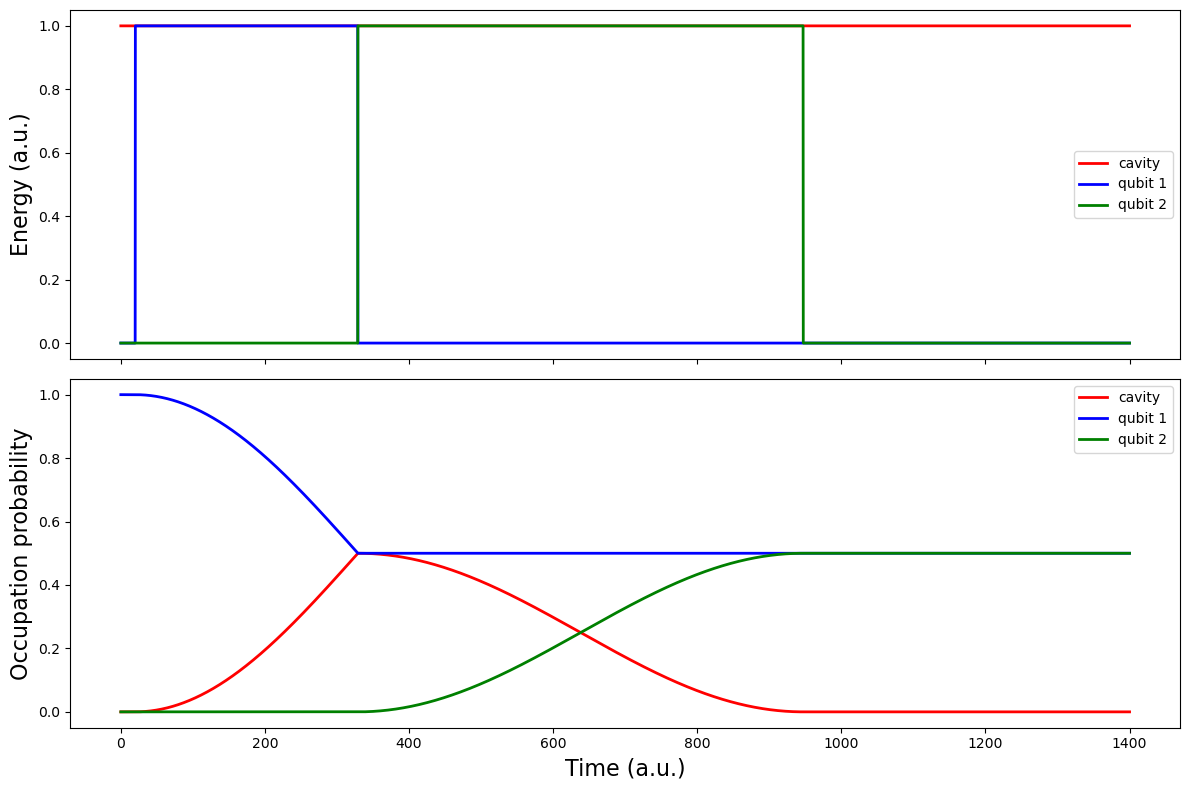

In [19]:
from numpy import real
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, array(list(map(wc_t, tlist))), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, array(list(map(w1_t, tlist))), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, array(list(map(w2_t, tlist))), 'g', linewidth=2, label="qubit 2")
#axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (a.u.)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, real(expect(ncav, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, real(expect(nq1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, real(expect(nq2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_xlabel("Time (a.u.)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

In [20]:
rho_final = res.states[-1]
rho_final

Quantum object: dims=[[2, 2, 2, 2, 2], [1, 1, 1, 1, 1]], shape=(32, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.        +0.00000000e+00j]
 [ 0.        -6.13711392e-06j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [-0.70710906+0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.7071045 +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000

In [21]:
# trace out the resonator mode and print the two-qubit density matrix
rho_qubits = ptrace(rho_final, [0,1])
rho_qubits

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 3.76641673e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  5.00003219e-01 -5.00000000e-01  0.00000000e+00]
 [ 0.00000000e+00 -5.00000000e-01  4.99996781e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]

In [22]:
rho_qubits_ideal1 = ket2dm(tensor(phasegate(0), phasegate(pi/2)) * sqrtiswap() * tensor(basis(2,1), basis(2,0)))
rho_qubits_ideal2 = ket2dm(tensor(phasegate(0), phasegate(-pi/2)) * sqrtiswap() * tensor(basis(2,1), basis(2,0)))

In [23]:
fidelity(rho_qubits, rho_qubits_ideal1)

np.float64(0.9999999999759864)

In [24]:
fidelity(rho_qubits, rho_qubits_ideal2)

np.float64(3.2191040339250527e-06)

In [25]:
concurrence(rho_qubits)

np.float64(0.9999999936765148)